In [46]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
# random seed to reproduce results
np.random.seed(42)


In [47]:
#downloading dataset
path = kagglehub.dataset_download("prasunroy/natural-images")

Using Colab cache for faster access to the 'natural-images' dataset.


In [48]:
#image size used through the model
IMG_SIZE = 128
#lists to store data
X = []
y = []
#inferring calss names based on folder names
class_names = sorted(os.listdir(path + "/natural_images"))
#look for each class folder
for label, cls in enumerate(class_names):
    cls_path = os.path.join(path, "natural_images", cls)
    #loop for each img
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        #resize img
        img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img = img_to_array(img)
        X.append(img)
        y.append(label)
#convert lists to numpy arrays
X = np.array(X) / 255.0
y = np.array(y)


In [57]:
#split to training, validation and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

#split training data to more training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full
)


In [50]:
#initialize
cnn = tf.keras.models.Sequential()
#first layer
cnn.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=7, activation="relu",
    padding="same", input_shape=(IMG_SIZE, IMG_SIZE, 3)
))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#secnofn layer
cnn.add(tf.keras.layers.Conv2D(128, kernel_size=3, activation="relu", padding="same"))
cnn.add(tf.keras.layers.Conv2D(128, kernel_size=3, activation="relu", padding="same"))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#3rd block
cnn.add(tf.keras.layers.Conv2D(256, kernel_size=3, activation="relu", padding="same"))
cnn.add(tf.keras.layers.Conv2D(256, kernel_size=3, activation="relu", padding="same"))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#flatten map to a vector
cnn.add(tf.keras.layers.Flatten())
#connecte d layers
cnn.add(tf.keras.layers.Dense(128, activation="relu"))
cnn.add(tf.keras.layers.Dense(64, activation="relu"))
cnn.add(tf.keras.layers.Dense(8, activation="softmax"))  # 8 classes

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,513,672 (36.29 MB)

 Trainable params: 9,513,672 (36.29 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
#compile using sparse categorical cross entropy
cnn.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [53]:
#train
history = cnn.fit(
    X_train, y_train,
    batch_size=64,
    epochs=10,
    validation_data=(X_valid, y_valid)
)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.2907 - loss: 1.8838 - val_accuracy: 0.7364 - val_loss: 0.7105
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7567 - loss: 0.6738 - val_accuracy: 0.8602 - val_loss: 0.3909
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8658 - loss: 0.3596 - val_accuracy: 0.8500 - val_loss: 0.4206
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9090 - loss: 0.2398 - val_accuracy: 0.8784 - val_loss: 0.3522
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9467 - loss: 0.1352 - val_accuracy: 0.8727 - val_loss: 0.3845
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9535 - loss: 0.1179 - val_accuracy: 0.8977 - val_loss: 0.3422
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9831 - loss: 0.0535 - val_accuracy: 0.8955 - val_loss: 0.4075
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9782 - loss: 0.0620 - val_accuracy: 0.8875 - 

In [54]:
#evaluate on test set
score = cnn.evaluate(X_test, y_test)

print("Total loss on Testing Set:", score[0])
print("Accuracy of Testing Set:", score[1])


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8734 - loss: 0.5175
Total loss on Testing Set: 0.500298023223877
Accuracy of Testing Set: 0.877294659614563


In [55]:
#selevt 3 random test sample
X_new = X_test[:3]
y_proba = cnn.predict(X_new)
y_pred = np.argmax(y_proba, axis=1)
#display predicte class names
np.array(class_names)[y_pred]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


array(['car', 'car', 'airplane'], dtype='<U9')

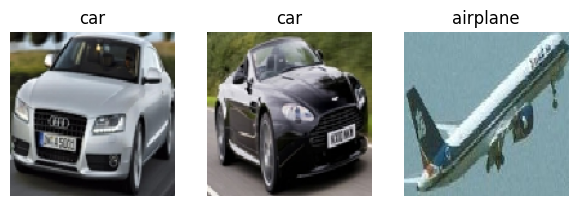

In [56]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image.astype("float32"))
    plt.axis("off")
    plt.title(class_names[y_test[index]])
plt.show()
